In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import TimeSeries
import pandas as pd
import os
import glob
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from uncertainties import ufloat
from uncertainties.umath import sqrt

In [2]:

# # Base directory where 'pulse_profiles' is located MA'AM's code
# base_dir = '/home/supremekai/thesis/J0243_6p6124/hxmt/pulse_profiles'

# # Search recursively for all matching fits files
# all_fits_files = glob.glob(os.path.join(base_dir, '**', '*_rms_deviation_flux_errors.fits'), recursive=True)

## When using efold output
base_dir = '/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output'

# Search recursively for all matching fits files
all_fits_files = glob.glob(
    #os.path.join(nicer_base_dir, '**', '*_rms_deviation_flux_errors.fits'),
    os.path.join(base_dir,'**','*_pulse_profile_efold_output_same_epoch.fits'),
    recursive=True
)


# Prepare separate lists
le_files = []
me_files = []
he_files = []

# Sort the files into LE, ME, HE
for file in all_fits_files:
    filename = os.path.basename(file)
    if '_LE_' in filename:
        le_files.append(file)
    elif '_ME_' in filename:
        me_files.append(file)
    elif '_HE_' in filename:
        he_files.append(file)

# Sort each list alphabetically (optional)
le_files.sort()
me_files.sort()
he_files.sort()

# Print or use the sorted lists
print(f"Total LE files: {len(le_files)}")
print(f"Total ME files: {len(me_files)}")
print(f"Total HE files: {len(he_files)}")

# Example: print first few from each
print("\nSample LE files:", le_files[:3])
print("Sample ME files:", me_files[:3])
print("Sample HE files:", he_files[:3])


Total LE files: 45
Total ME files: 56
Total HE files: 48

Sample LE files: ['/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600101/LE/P050419600101_LE_pulse_profile_efold_output_same_epoch.fits', '/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600102/LE/P050419600102_LE_pulse_profile_efold_output_same_epoch.fits', '/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600201/LE/P050419600201_LE_pulse_profile_efold_output_same_epoch.fits']
Sample ME files: ['/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600101/ME/P050419600101_ME_pulse_profile_efold_output_same_epoch.fits', '/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600102/ME/P050419600102_ME_pulse_profile_efold_output_same_epoch.fits', '/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output/P050419600103/ME/P050419600103_ME_pulse_profile_efold_output_same_epoch.fits']
Sample HE files: ['/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_

In [3]:
def read_files(path):
    profile = fits.open(path)
    data = profile[1].data
    binned_rate = data['RATE1']
    phase = data['PHASE']
    binned_rate_error = data['ERROR1']
    
    N = len(binned_rate)
    r_i = [ufloat(binned_rate[i], binned_rate_error[i]) for i in range(N)]

    I_max = max(r_i)
    I_min = min(r_i)
    pulsed_fraction = (I_max - I_min) / (I_max + I_min)

    r_bar = sum(r_i) / N
    numerator = sqrt(sum((r - r_bar) ** 2 for r in r_i) / N)
    rms_pulsed_fraction = numerator / r_bar

    return phase, binned_rate, binned_rate_error, pulsed_fraction, rms_pulsed_fraction


    # def calculate_rms(phase, binned_rate, binned_rate_error):
    #     # Convert binned_rate and errors into uncertainty-aware values
    #     N = len(binned_rate)
    #     r_i = [ufloat(binned_rate[i], binned_rate_error[i]) for i in range(N)]

    #     # Compute max and min intensities (with uncertainty)
    #     I_max = max(r_i)
    #     I_min = min(r_i)

    #     # Pulsed fraction (with uncertainty propagation)
    #     pulsed_fraction = (I_max - I_min) / (I_max + I_min)

    #     # Compute mean count rate with uncertainty
    #     r_bar = sum(r_i) / N  

    #     # Compute RMS pulsed fraction (with uncertainty propagation)
    #     numerator = sqrt(sum((r - r_bar) ** 2 for r in r_i) / N)  # RMS term
    #     rms_pulsed_fraction = numerator / r_bar  

    #     # Extract values and uncertainties
    #     pf_value, pf_uncertainty = rms_pulsed_fraction.nominal_value, rms_pulsed_fraction.std_dev

    #     return pulsed_fraction.nominal_value, pf_value, pf_uncertainty


def calc_pf_plot(lc_arr,plot=True):
    pf_arr=np.array([])
    rmspf_arr=np.array([])
    for lc in lc_arr: 
        phase_arr, intensity_arr,error_arr, pf,rmspf = read_files(lc)
        pf_arr=np.append(pf_arr,pf)
        rmspf_arr=np.append(rmspf_arr,rmspf)
        # Print the results
        print(f"File: {lc}")
        print(f"Max photon flux: {intensity_arr.max():.4f} counts/sec")
        print(f"Pulsed Fraction: {pf:.4f}, RMS Pulsed Fraction: {rmspf:.4f}")
        
        # Repeat the phase, intensity, and error to plot twice for visual appearance (phase 0 to 2)
        phase_arr_double = np.concatenate([phase_arr, phase_arr + 1])
        intensity_arr_double = np.concatenate([intensity_arr, intensity_arr])
        error_arr_double = np.concatenate([error_arr, error_arr])
        if(plot==True):
            plt.figure(figsize=(8,4))
            plt.errorbar(phase_arr_double, intensity_arr_double, yerr=error_arr_double, fmt='-o', capsize=2, label='Light Curve',alpha=0.7)
            plt.xlabel("Phase (0-2)")
            plt.ylabel("Flux (counts/sec)")
            plt.title(f"Folded Light Curve (2 Cycles)\nPulsed Fraction: {rmspf:.4f}")
            plt.grid(True)
            plt.legend()
            plt.show()
    return pf_arr,rmspf_arr

In [4]:
def extract_exp_id(filepath):
    """Extract exposure ID or unique identifier from the filename."""
    return os.path.basename(filepath).split('_')[0]

def process_group(file_list, label, save_dir='./pf_results', plot=False):
    """Calculate and save pulsed fraction and RMS pulsed fraction for a group, with uncertainties."""
    pf_data = []

    os.makedirs(save_dir, exist_ok=True)

    for file_path in file_list:
        try:
            phase, intensity, error, pf, rms_pf = read_files(file_path)
            exp_id = extract_exp_id(file_path)

            pf_data.append({
                "ExposureID": exp_id,
                "FilePath": file_path,
                "PulsedFraction": round(pf.nominal_value, 5),
                "PulsedFraction_Error": round(pf.std_dev, 5),
                "RMS_PulsedFraction": round(rms_pf.nominal_value, 5),
                "RMS_PulsedFraction_Error": round(rms_pf.std_dev, 5)
            })

            if plot:
                calc_pf_plot([file_path], plot=True)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    # Save to CSV
    df = pd.DataFrame(pf_data)
    csv_path = os.path.join(save_dir, f'{label}_pulsed_fractions.csv')
    df.to_csv(csv_path, index=False)
    print(f"Saved {label.upper()} results to: {csv_path}")

def main():
    base_dir = '/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_efold_output'
    all_fits_files = glob.glob(
        os.path.join(base_dir, '**', '*_pulse_profile_efold_output_same_epoch.fits'),
        recursive=True
    )

    le_files, me_files, he_files = [], [], []

    for file in all_fits_files:
        filename = os.path.basename(file)
        if '_LE_' in filename:
            le_files.append(file)
        elif '_ME_' in filename:
            me_files.append(file)
        elif '_HE_' in filename:
            he_files.append(file)

    le_files.sort()
    me_files.sort()
    he_files.sort()

    print(f"LE files: {len(le_files)}, ME files: {len(me_files)}, HE files: {len(he_files)}")

    # Process each group
    process_group(le_files, 'LE')
    process_group(me_files, 'ME')
    process_group(he_files, 'HE')

if __name__ == '__main__':
    main()


LE files: 45, ME files: 56, HE files: 48
Saved LE results to: ./pf_results/LE_pulsed_fractions.csv
Saved ME results to: ./pf_results/ME_pulsed_fractions.csv
Saved HE results to: ./pf_results/HE_pulsed_fractions.csv


## Plotting RMS and PF for the instrument

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
# at top of your scripts, once:

plt.style.use('astro')  # if in ~/.config/matplotlib/stylelib/astro.mplstyle


In [6]:
# Paths to your files
le_pf_csv = '/home/supremekai/thesis/J0243_6p6124/HXMT/pf_results/LE_pulsed_fractions.csv'
me_pf_csv = '/home/supremekai/thesis/J0243_6p6124/HXMT/pf_results/ME_pulsed_fractions.csv'
he_pf_csv = '/home/supremekai/thesis/J0243_6p6124/HXMT/pf_results/HE_pulsed_fractions.csv'
spectra_csv = '/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt_reporting_spectra.csv'

# Load data
le_df = pd.read_csv(le_pf_csv)
me_df = pd.read_csv(me_pf_csv)
he_df = pd.read_csv(he_pf_csv)
spectra_df = pd.read_csv(spectra_csv,sep="\t",comment="#")

# Merge only the ID and Luminosity columns
spectra_subset = spectra_df[['ID', 'Lumin']].copy()

le_df['ExposureID'] = le_df['ExposureID'].astype(str).str.strip()
me_df['ExposureID'] = me_df['ExposureID'].astype(str).str.strip()
he_df['ExposureID'] = he_df['ExposureID'].astype(str).str.strip()
spectra_subset['ID'] = spectra_subset['ID'].astype(str).str.strip()


In [7]:
# Merge PF data (ExposureID) with spectra data (ID)
le_merged = le_df.merge(spectra_subset, left_on='ExposureID', right_on='ID', how='left')
me_merged = me_df.merge(spectra_subset, left_on='ExposureID', right_on='ID', how='left')
he_merged = he_df.merge(spectra_subset, left_on='ExposureID', right_on='ID', how='left')

In [8]:
he_merged.head(20)

,ExposureID,FilePath,PulsedFraction,PulsedFraction_Error,RMS_PulsedFraction,RMS_PulsedFraction_Error,ID,Lumin
0,P050419600101,/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt...,0.48615,0.00709,0.33589,0.00163,P050419600101,5.240000e+37
1,P050419600102,/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt...,0.52474,0.01643,0.33682,0.00366,P050419600102,5.180000e+37
2,P050419600103,/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt...,0.54848,0.01759,0.38191,0.00417,NaN,NaN
3,P050419600201,/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt...,0.68874,0.02137,0.50429,0.00503,P050419600201,4.990000e+37
4,P050419600202,/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt...,0.47132,0.00620,0.32485,0.00141,P050419600202,4.970000e+37
5,P050419600301,/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt...,0.57652,0.01203,0.41131,0.00280,P050419600301,4.700000e+37
6,P050419600302,/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt...,0.78170,0.03259,0.58110,0.00808,P050419600302,4.770000e+37
7,P050419600303,/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt...,0.51934,0.00781,0.35553,0.00178,P050419600303,5.000000e+37
8,P050419600402,/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt...,0.53820,0.00906,0.36998,0.00210,P050419600402,4.780000e+37
9,P050419600403,/home/supremekai/thesis/J0243_6p6124/HXMT/hxmt...,0.52614,0.01167,0.33060,0.00258,NaN,NaN


In [9]:
df=pd.read_csv('/home/supremekai/thesis/J0243_6p6124/NICER_second_run/pf_results/NICER_pulsed_fractions.csv',sep=',')
#/home/supremekai/thesis/J0243_6p6124/NICER_second_run/pf_results
df_nicer_spectra=pd.read_csv('/home/supremekai/thesis/J0243_6p6124/NICER/reporting_spectra_iteration_3.csv',sep='\t')
# df=pd.read_csv('rms_pulsed_rms_lc_file_barycorr_orbit.txt',sep='\t')
# Merge PF data (ExposureID) with spectra data (ID)
nicer_merged = df.merge(df_nicer_spectra[['Obs ID','Lumin']], left_on='ObsID', right_on='Obs ID', how='left')

In [10]:
le_sorted = le_merged.sort_values(by='Lumin')
he_sorted = he_merged.sort_values(by='Lumin')
me_sorted = me_merged.sort_values(by='Lumin')

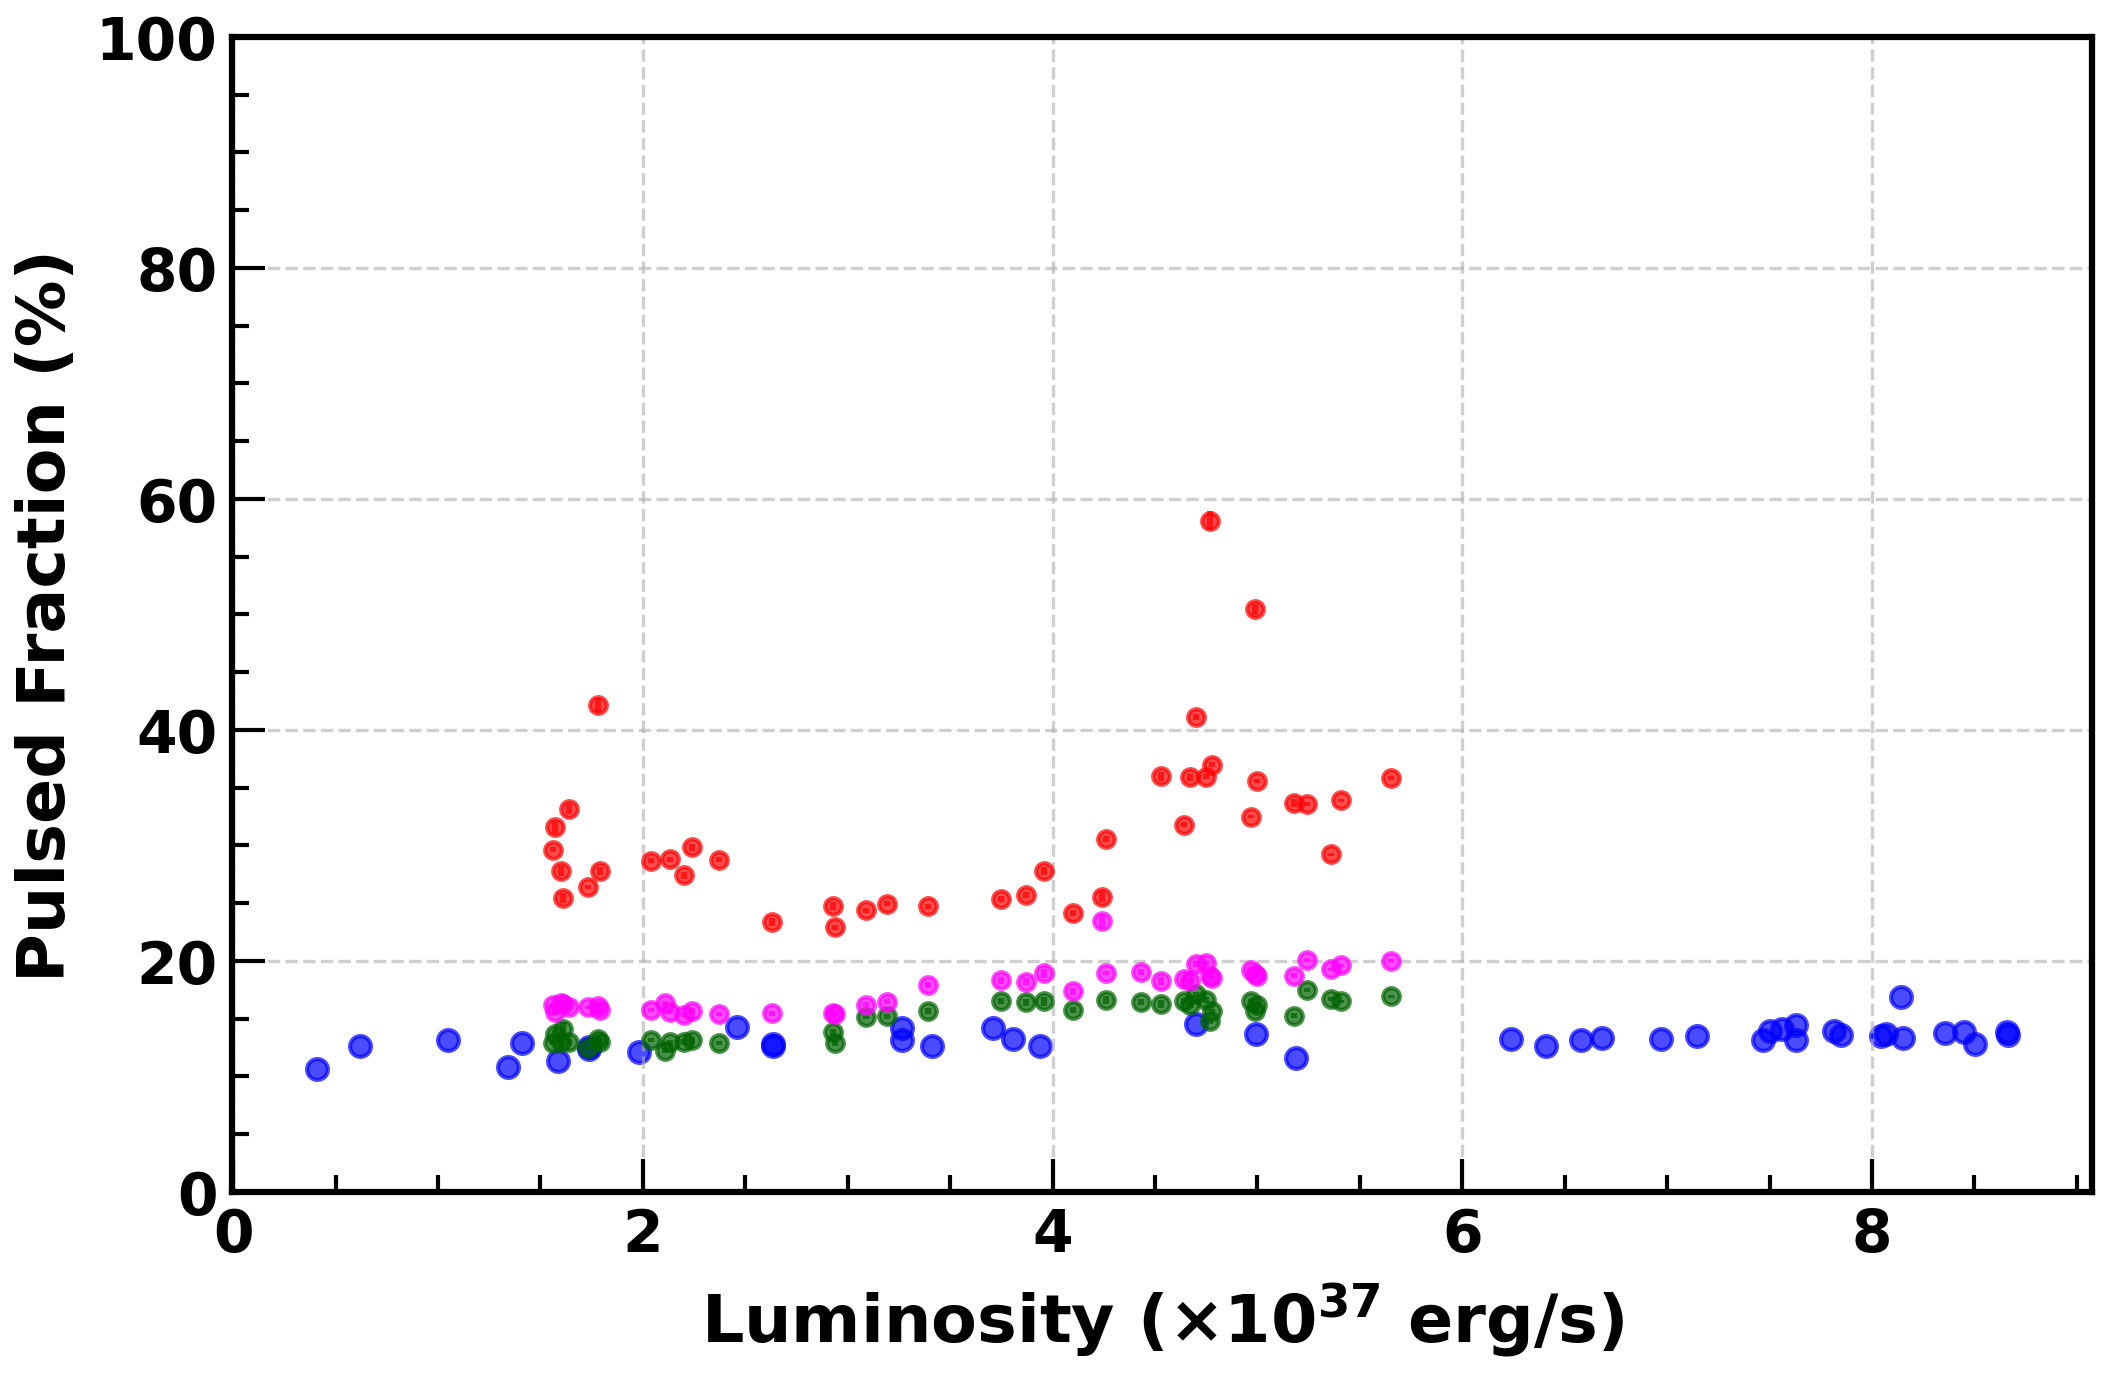

In [12]:
# Plot RMS Pulsed Fraction vs Lumin
plt.figure(figsize=(8, 5))
plt.errorbar(le_sorted['Lumin']/1e37, le_sorted['RMS_PulsedFraction']*100,yerr=le_sorted['RMS_PulsedFraction_Error']*100,fmt='o',label='LE', color='darkgreen', alpha=0.7,markersize=4)
plt.errorbar(me_sorted['Lumin']/1e37, me_sorted['RMS_PulsedFraction']*100,yerr=me_sorted['RMS_PulsedFraction_Error']*100,fmt='o',label='ME', color='magenta', alpha=0.7,markersize=4)
plt.errorbar(he_sorted['Lumin']/1e37, he_sorted['RMS_PulsedFraction']*100,yerr=he_sorted['RMS_PulsedFraction_Error']*100,fmt='o', label='HE', color='red', alpha=0.7,markersize=4)
#plt.scatter(nicer_merged['Lumin']/1e37, nicer_merged['RMS_PF']*100, label='NICER', color='blue', alpha=0.7,marker='o',s=25)
plt.scatter(nicer_merged['Lumin']/1e37, nicer_merged['RMS_PulsedFraction']*100, label='NICER', color='blue', alpha=0.7,marker='o',s=25)


#plt.xscale('log')
plt.minorticks_on()
plt.xlabel(r"Luminosity ($\times 10^{37}$ erg/s)")
plt.ylabel("Pulsed Fraction (%)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.minorticks_on()
plt.ylim(0,100)
plt.savefig('/home/supremekai/thesis/J0243_6p6124/plot_rmspf_variation_for_all.png')

In [38]:
le_sorted[he_sorted['RMS_PulsedFraction'] < 0.10]

/tmp/ipykernel_18600/2240435033.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  le_sorted[he_sorted['RMS_PulsedFraction'] < 0.10]


,ExposureID,FilePath,PulsedFraction,PulsedFraction_Error,RMS_PulsedFraction,RMS_PulsedFraction_Error,ID,Lumin
